# AG News — решение с Transformer (DistilBERT)

Этот ноутбук обучает `distilbert-base-uncased` на датасете **AG News** и считает **macro F1** на test.
Также строит графики обучения (loss/F1 по эпохам) и **confusion matrix**.

> Цель: **macro F1 ≥ 0.95** на test.


In [8]:
# Установка зависимостей
!pip -q install transformers datasets accelerate evaluate scikit-learn matplotlib


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [13]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    set_seed,
)

from sklearn.metrics import f1_score, confusion_matrix

In [14]:
# Фиксируем seed для воспроизводимости
SEED = 42
set_seed(SEED)

print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

CUDA available: True
GPU: NVIDIA GeForce RTX 5070 Ti


## 1) Загружаем датасет AG News

`datasets` уже содержит готовые split-ы `train` и `test`.


In [15]:
ds = load_dataset("ag_news")
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

## 2) Токенизация

Используем `max_length=256` (часто чуть стабильнее, чем 128).
`DataCollatorWithPadding` делает динамический padding по батчу.


In [16]:
model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_fn(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        max_length=256,
    )

ds_tok = ds.map(tokenize_fn, batched=True, remove_columns=["text"])
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

ds_tok

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 7600
    })
})

## 3) Модель

`num_labels=4`, потому что в AG News 4 класса.


In [17]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=4
)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 4) Метрика macro F1

Нужна именно **macro F1** (среднее по классам, каждый класс равновесен).


In [18]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    f1 = f1_score(labels, preds, average="macro")
    acc = (preds == labels).mean()
    return {"accuracy": acc, "f1_macro": f1}

## 5) Обучение

Рекомендованные параметры под AG News:
- `learning_rate=2e-5`
- `epochs=3`
- `weight_decay=0.01`
- `warmup_ratio=0.1`

Если вдруг будет OOM по памяти — уменьшай `per_device_train_batch_size` до 16.


In [19]:
args = TrainingArguments(
    output_dir="./agnews_roberta",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,

    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    weight_decay=0.01,
    warmup_ratio=0.1,

    fp16=torch.cuda.is_available(),
    logging_strategy="epoch",
    report_to="none",
    seed=SEED,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=ds_tok["train"],
    eval_dataset=ds_tok["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

train_out = trainer.train()
metrics = trainer.evaluate()
metrics

C:\Users\СИВ\AppData\Local\Temp\ipykernel_37752\3365628113.py:22: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.288500,0.199305,0.941711,0.941889
2,0.165600,0.186213,0.950132,0.950150
3,0.120100,0.202379,0.954211,0.954186


{'eval_loss': 0.202379047870636,
 'eval_accuracy': 0.9542105263157895,
 'eval_f1_macro': 0.954186145816266,
 'eval_runtime': 5.5343,
 'eval_samples_per_second': 1373.244,
 'eval_steps_per_second': 21.502,
 'epoch': 3.0}

## 6) Графики обучения (loss и F1)

`Trainer` хранит логи в `trainer.state.log_history`.


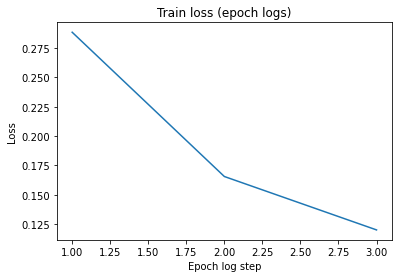

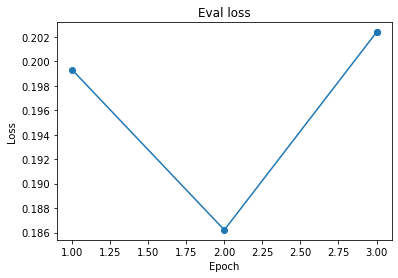

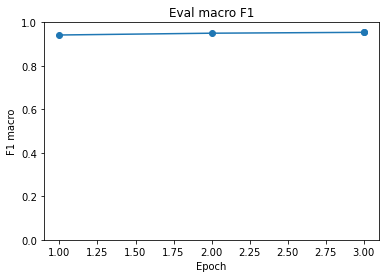

In [20]:
log_history = trainer.state.log_history

train_loss = []
eval_loss = []
eval_f1 = []
epochs = []

for row in log_history:
    if "epoch" in row:
        ep = row["epoch"]
        if "loss" in row and "eval_loss" not in row:
            train_loss.append(row["loss"])
        if "eval_loss" in row:
            epochs.append(ep)
            eval_loss.append(row["eval_loss"])
            eval_f1.append(row.get("eval_f1_macro"))

plt.figure()
plt.plot(range(1, len(train_loss) + 1), train_loss)
plt.title("Train loss (epoch logs)")
plt.xlabel("Epoch log step")
plt.ylabel("Loss")
plt.show()

plt.figure()
plt.plot(epochs, eval_loss, marker="o")
plt.title("Eval loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

plt.figure()
plt.plot(epochs, eval_f1, marker="o")
plt.title("Eval macro F1")
plt.xlabel("Epoch")
plt.ylabel("F1 macro")
plt.ylim(0, 1.0)
plt.show()

## 7) Confusion matrix на test

Печатаем также итоговый macro F1 на test.


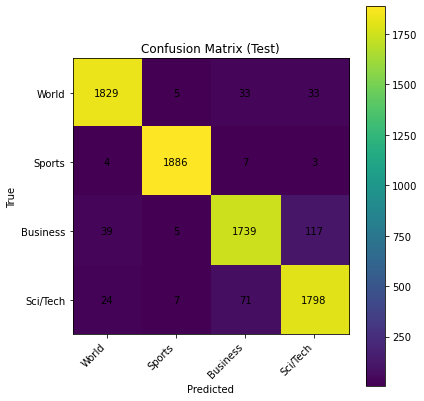

macro F1 (test): 0.954186145816266


In [21]:
pred = trainer.predict(ds_tok["test"])
logits = pred.predictions
y_true = pred.label_ids
y_pred = np.argmax(logits, axis=-1)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 6))
plt.imshow(cm)
plt.title("Confusion Matrix (Test)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()

labels = ["World", "Sports", "Business", "Sci/Tech"]
plt.xticks([0, 1, 2, 3], labels, rotation=45, ha="right")
plt.yticks([0, 1, 2, 3], labels)

for i in range(4):
    for j in range(4):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.tight_layout()
plt.show()

print("macro F1 (test):", f1_score(y_true, y_pred, average="macro"))

## Примечания

- Если ноутбук запускается на CPU, проверь что установлена GPU-версия PyTorch и видна CUDA.
- Для ещё более высокой метрики можно попробовать `roberta-base`, но он тяжелее.
